In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dgutils import colors as colortools
from dgutils import savehtml
from pimcscripts import pimchelp

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#sorted(plt.style.available)
plt.style.use('classic')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Reduce the data over temperature and laod the resulting files

In [5]:
sim_params = {'τ':0.002, 'N':1, 'n':0.05}

In [6]:
data_dir = './data/'
!reduce-one.py -r T -N 1 -s 0.2 -n {sim_params['n']} -t {sim_params['τ']} --canonical {data_dir}

Reduced lineardensity over 6 Temperature value(s).
Reduced virial over 6 Temperature value(s).


In [7]:
est_reduce_name = pimchelp.get_reduce_name(**sim_params,canonical=True,reduce='T', estimator='virial')
estimator = pimchelp.PIMCResults(f'{data_dir}{est_reduce_name}')
rho_reduce_name = pimchelp.get_reduce_name(**sim_params,canonical=True,reduce='T',estimator='lineardensity')
rho = pimchelp.PIMCResults(f'{data_dir}{rho_reduce_name}')

## Study the Energy vs. Temperature

In [8]:
E = lambda T: 0.5/np.tanh(0.5/T)
_T = np.linspace(1E-6,2,1000)

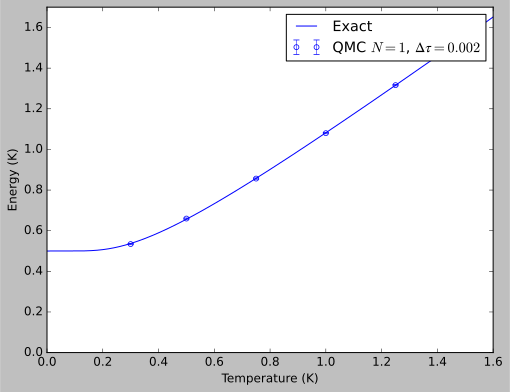

In [9]:
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None', 'mew':0.75, 'mec':colors[0]}

T = estimator.data['T']
plt.errorbar(T, estimator.data['E'], yerr=estimator.data['ΔE'], **params, label=f"QMC $N=1$, $Δτ={sim_params['τ']}$")
plt.plot(_T, E(_T), lw=1, color=colors[0], label='Exact')
plt.xlim(0,1.6)
plt.ylim(0.0,1.7)
plt.ylabel('Energy (K)')
plt.xlabel('Temperature (K)')
plt.legend()
plt.savefig('./plot/E_vs_T_SHO_N!.png', dpi=300)

## Investigate the probaility density

In [10]:
rho_exact = lambda x,T: np.exp(-x**2*np.tanh(0.5/T))/np.sqrt(np.pi/np.tanh(0.5/T))
_x = np.linspace(-5,5,1000)

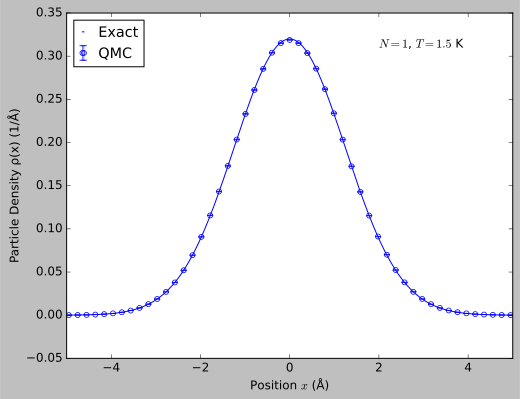

In [11]:
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None', 'mew':0.75, 'mec':colors[0]}

T_compare = 1.5
idx = np.where(np.abs(T-T_compare) < 0.01)[0][0]
x,rhox,drhox = rho.epdata(rho.params[idx])
deltaX = x[2] - x[1]

fig,ax = plt.subplots()

ax.errorbar(x+deltaX/2,rhox,yerr=drhox,**params, label=f'QMC')
ax.plot(_x, rho_exact(_x, T_compare), '-', lw=1, color=colors[0], label = 'Exact')
ax.text(0.7,0.9, f'$N=1$, $T={T_compare}$ K', fontsize=12, transform=ax.transAxes)
ax.set_xlim(-5,5)
ax.set_xlabel('Position $x$ (Å)')
ax.set_ylabel('Particle Density ρ(x) (1/Å)')
ax.legend(loc='upper left', handlelength=0.5)
plt.savefig('./plot/rho_vs_xT_1.5_SHO_NA.png', dpi=300)

## Now let's make a grid for all temperatures

In [12]:
colors = colortools.get_linear_colors('Spectral',len(T),reverse=True)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':3, 'lw':0.75, 'ls':'None', 'mew':0.75}

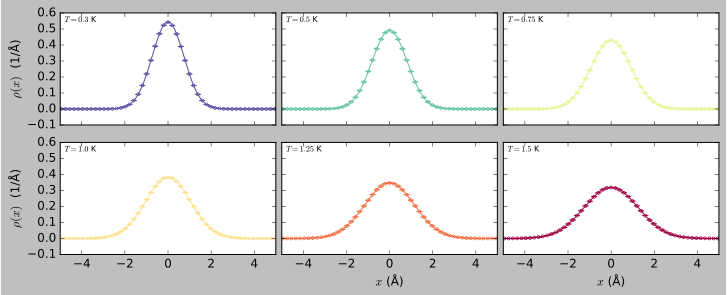

In [15]:
figsize = (10,4)
fig,axes = plt.subplots(nrows=2,ncols=3,sharex=True,sharey=True,constrained_layout=True,squeeze=True, figsize=figsize)
for i, ax in enumerate(axes.flat):
	cT = T[i]
	x,rhox,drhox = rho.epdata(rho.params[i])
	ax.errorbar(x+deltaX/2,rhox,yerr=drhox, **params, label=f'QMC', mec=colors[i], ecolor=colors[i])
	ax.plot(_x, rho_exact(_x,cT), '-', lw=1, color=colors[i], label='Exact')
	ax.set_xlim(-5,5)
	ax.text(0.02, 0.92,f'$T={cT}$ K',transform=ax.transAxes, fontsize=8)
	if i > 3:
		ax.set_xlabel('$x$ (Å)')

axes[0,0].set_ylabel(r'$\rho(x)$  (1/Å)')
axes[1,0].set_ylabel(r'$\rho(x)$  (1/Å)');

plt.savefig('./plot/rho_vs_xT_SHO_N1.png', dpi=300)

## Quantifying with $\chi^2$

In [17]:
chi2 = []
for iT, cT in enumerate(T):
	x,rhox,drhox = rho.epdata(rho.params[iT])
	x+= deltaX/2
	chi2.append(np.average(((rho_exact(x,cT) - rhox))**2))

chi2 = np.array(chi2)

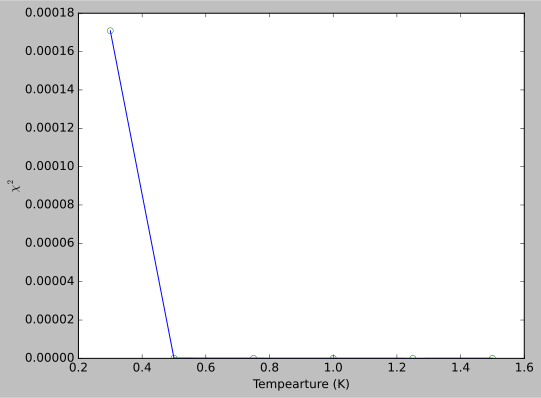

In [20]:
plt.plot(T,chi2)
plt.plot(T,chi2,'o',fillstyle='none')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Tempearture (K)')
plt.savefig('./plot/chi2_vs_T_SHO_N1.png',dpi=300)